# Replicating "Mining Brand Perceptions from Twitter Social Networks"

Here we provide code to reproduce the figures and tables in the paper "Mining Brand Perceptions from Twitter Social Networks," by Aron Culotta and Jennifer Cutler, published in *Marketing Science*.

The analysis requires data crawled from Twitter. To enable direct reproduction of our results, we have provided the social network data we have collected. Additionally, we have provided the code we used to collect such data, should you want to reproduce using data from a different time period or with a different set of brands. So, if you want to reproduce our figures exactly, you should run the <a href="#download_data">Download Data</a> section; otherwise, to collect new data, you should run the <a href="#collect_data">Collect Data</a> cells.
<br><br>
**Table of Contents**

1. <a href="#setup">Setup</a>
2. <a href="download_data">Download Data</a>
3. <a href="#collect_data">Collect Data</a>
  1. <a href="#data_collection_brands">Brands</a>
  2. <a href="#data_collection_exemplars">Exemplars</a>
4. <a href="#analysis">Main Analysis</a>
  1. <a href="#analysis_evaluation">Evaluation</a> 
5. <a href="#robustness">Robustness Checks</a>
  1. <a href="#sensitivity_min_followers">Number of followers per exemplar</a>
  2. <a href="#sensitivity_nexemplars">Number of exemplars</a>
  3. <a href="#manual_exemplars">Manual vs Auto Exemplars</a>
  4. <a href="#exemplar_accuracy">Accuracy per exemplar</a>
  5. <a href="#accuracy_v_exemplar_followers">Accuracy by popularity of exemplar</a>


<a name="setup"></a>

## Setup

This notebook assumes you're using Python3.

All analysis uses Python. It uses our [`brandelion`](https://github.com/tapilab/brandelion) library, which in turn depends on our [`twutil`](https://github.com/tapilab/twutil) library.

To install python requirements, do:
```
pip install -r requirements.txt
```

To collect new data, you'll need to set your Twitter credentials as environmental variables (see `twutil`'s documentation).

Set the variable `BRAND_DATA` below to be the path where all data will be stored. E.g.:

In [1]:
import os
BRAND_DATA = 'mksci-data'
!mkdir -p $BRAND_DATA
os.environ['BRANDELION_CFG'] = '.brandelion'

In [2]:
# Imports and global variables.
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scistat
import string
from tabulate import tabulate

import brandelion.cli.analyze as analyze
import brandelion.cli.report as report

measures = ['cosine', 'jaccard', 'proportion']
subtypes = ['', '_weighted_avg', '_sqrt_no_weighted_avg', '_sqrt']
all_score_types = [m + s for m in measures for s in subtypes]
perceptions = [('eco', ['apparel', 'car', 'food', 'personal_care']),
               ('luxury', ['apparel', 'car']),
               ('nutrition', ['food'])]
%matplotlib inline

## Download Data

<a name="download_data"></a>

In [9]:
# Download the original source data (~333M zipped, ~771M unzipped)
try:  # python3
    from urllib.request import urlretrieve
except: # python2
    from urllib import urlretrieve

data_url = 'https://www.dropbox.com/s/rvzn98l3a3278v9/mksci-data.tgz?dl=1'
zipfile = BRAND_DATA + '/mksci-data.tgz'
print('downloading %s to %s' % (data_url, zipfile))
urlretrieve(data_url, zipfile) 

downloading https://www.dropbox.com/s/rvzn98l3a3278v9/mksci-data.tgz?dl=1 to mksci-data/mksci-data.tgz


In [ ]:
# unzip
!tar xvf $zipfile -C $BRAND_DATA --strip-components=1

<a name="collect_data"></a>
## Collect Data

We collect Twitter follower information for a set of brands, as well as a set of exemplar accounts representing a particular perception dimension (e.g., the environment). (Note, please skip to <a href="#analysis">Analysis</a> section if you've already downloaded the original data above.)

<a name="data_collection_brands"></a>
### Brands


- We scrape [GoodGuide](http://goodguide.com) for a list of brands from Apparel, Food, Cars, Personal Care categories.
- We run an semi-automated method to collect Twitter accounts for each brand.
- We filter accounts that have low Twitter presence, defined as fewer than 1,000 followers or fewer than 100 tweets.
- The final list of brands is stored in `$BRAND_DATA/brands.txt`

In [66]:
def print_lines(filename):
    nlines = !wc -l $filename
    print('There are %s lines in %s' % (nlines[0].split()[0], filename))
    print('\nThe first 5 are:')
    !head -5 $filename
    
print_lines(BRAND_DATA + '/brands.txt')

There are 168 lines in data/brands.txt

The first 5 are:
abercrombie
acura
adidasus
aeropostale
airheads


For each brand, we collect up to 500K followers:

In [ ]:
# This will take a long time (~24 hours); we sleep when rate limit reached.
# Note that Twitter currently sorts results by recency, so you may get a slightly
# different follower list each time this is run.
# Note also that the brandelion output format has changed slightly since we originally collected the data, so 
# we have modified the brand_followers.txt files accordingly to reflect that new format.
!brandelion collect --followers -i $BRAND_DATA/brands.txt  -o $BRAND_DATA/brand_followers.txt -m 500000
# Unzip the followers file.
!gunzip $BRAND_DATA/brand_followers.txt.gz

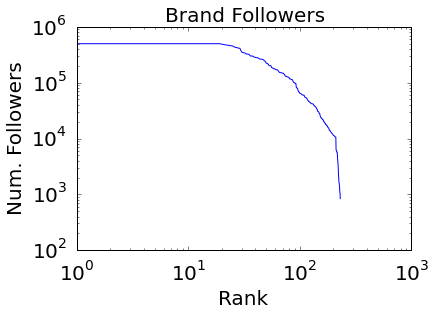

In [20]:
def log_plot(filename, values, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', labelsize='20')
    ax.tick_params(axis='both', pad=10)
    plt.plot(values)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel(xlabel, size='20')
    plt.ylabel(ylabel, size='20')
    plt.title(title, size='20')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()
    
def plot_follower_distribution(filename, outfile, title):
    brand_followers = analyze.read_follower_file(filename)
    brand_follower_counts = sorted([len(followers) for followers in brand_followers.values()], reverse=True)
    log_plot(outfile, brand_follower_counts, 'Rank', 'Num. Followers', title)
    
plot_follower_distribution(BRAND_DATA + '/brand_followers_unfiltered.txt', 'brand_follower_counts.pdf', 'Brand Followers')

In [22]:
def print_follower_stats(fname):
    brand_followers = analyze.read_follower_file(fname)
    print('%d total brands' % (len(brand_followers)))
    print('%d total follow links' % (sum(len(x) for x in brand_followers.values())))
    uniq_followers = set()
    for f in brand_followers.values():
        uniq_followers |= f
    print('%d unique followers' % (len(uniq_followers)))

In [23]:
# Print stats restricted to the 168 brands retained after survey filters.
print_follower_stats(BRAND_DATA + '/brand_followers.txt')

168 total brands
28031984 total follow links
13792852 unique followers


In [24]:
# Print stats for all original brands (excepting a few whose twitter handles have changed)
print_follower_stats(BRAND_DATA + '/brand_followers_unfiltered.txt')

231 total brands
30612190 total follow links
14628373 unique followers


<a name="data_collection_exemplars"></a>
## Exemplars

We consider three dimensions of perception: Environment, Nutrition, and Luxury. We will score brands based on their alignment with each perception dimension.

To do so, we first collect a list of Twitter accounts that are representative of each perception dimension. We call these **exemplars.**

These are collected by searching Twitter for the top 20 lists matching a keyword (e.g., "environment", "nutrition", etc.), then keeping accounts that appear on at least two lists. 

In [25]:
# First, let's make subdirectories for each perception type.
!mkdir -p $BRAND_DATA/eco $BRAND_DATA/nutrition $BRAND_DATA/luxury

In [ ]:
# Collect Environment exemplars using the search term "environment."
!brandelion collect --exemplars -q environment --output $BRAND_DATA/eco/exemplars.txt

In [41]:
print_lines(BRAND_DATA + '/eco/exemplars.txt')

There are 73 lines in data/eco/exemplars.txt

The first 5 are:
APA_Planning
EPAresearch
NWF
neelaeast
KateGalbraith


In [ ]:
# Collect Nutrition exemplars.
!brandelion collect --exemplars -q nutrition --output $BRAND_DATA/nutrition/exemplars.txt

In [42]:
print_lines(BRAND_DATA + '/nutrition/exemplars.txt')

There are 407 lines in data/nutrition/exemplars.txt

The first 5 are:
PaffRD
McDanielRDN
AsktheDietitian
DaniNierenberg
kittenwithawhip


In [ ]:
# Collect Luxury exemplars.
!brandelion collect --exemplars -q luxury --output $BRAND_DATA/luxury/exemplars.txt

In [30]:
# Remove BMWGroup from luxury exemplars, since very similar to bmwusa in brands.txt
!cat $BRAND_DATA/luxury/exemplars.txt | egrep -iv bmwgroup > $BRAND_DATA/luxury/tmp
!mv -f $BRAND_DATA/luxury/tmp $BRAND_DATA/luxury/exemplars.txt

In [43]:
print_lines(BRAND_DATA + '/luxury/exemplars.txt')

There are 110 lines in data/luxury/exemplars.txt

The first 5 are:
BALENCIAGA
NETAPORTER
Audi
lmaoseriously
francasozzani


In [44]:
# If some exemplars are on the brands list, we remove them.
!cat $BRAND_DATA/luxury/exemplars.txt $BRAND_DATA/brands.txt | sort | uniq -d > $BRAND_DATA/luxury/dups
if(len(open(BRAND_DATA+'/luxury/dups').readlines()) > 0):
    !egrep -vf $BRAND_DATA/luxury/dups $BRAND_DATA/luxury/exemplars.txt > $BRAND_DATA/luxury/.tmp
    !mv $BRAND_DATA/luxury/.tmp $BRAND_DATA/luxury/exemplars.txt
    
print_lines(BRAND_DATA + '/luxury/exemplars.txt')

There are 110 lines in data/luxury/exemplars.txt

The first 5 are:
BALENCIAGA
NETAPORTER
Audi
lmaoseriously
francasozzani


** Next, we collect up to 50k followers of each exemplar. **

In [ ]:
!brandelion collect --followers -i $BRAND_DATA/eco/exemplars.txt  -o $BRAND_DATA/eco/exemplar_followers.txt.gz -m 50000
# unzip results.
!gunzip $BRAND_DATA/eco/exemplar_followers.txt.gz

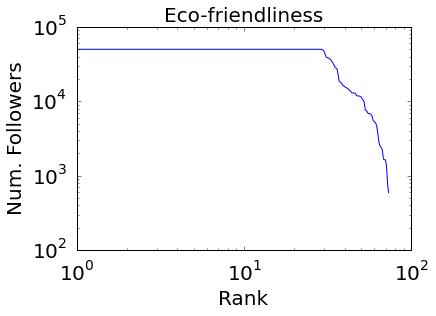

In [45]:
plot_follower_distribution(BRAND_DATA + '/eco/exemplar_followers.txt', 'eco_follower_counts.pdf', 'Eco-friendliness')

In [179]:
print_follower_stats(BRAND_DATA + '/eco/exemplar_followers.txt')

74 total brands
2050446 total follow links
1043342 unique followers


In [ ]:
!brandelion collect --followers -i $BRAND_DATA/nutrition/exemplars.txt  -o $BRAND_DATA/nutrition/exemplar_followers.txt.gz -m 50000
# unzip results.
!gunzip $BRAND_DATA/nutrition/exemplar_followers.txt.gz

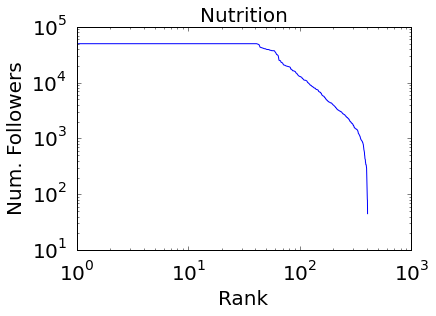

In [46]:
plot_follower_distribution(BRAND_DATA + '/nutrition/exemplar_followers.txt', 'nutrition_follower_counts.pdf', 'Nutrition')

In [47]:
print_follower_stats(BRAND_DATA + '/nutrition/exemplar_followers.txt')

405 total brands
4740031 total follow links
2683775 unique followers


In [ ]:
!brandelion collect --followers -i $BRAND_DATA/luxury/exemplars.txt  -o $BRAND_DATA/luxury/exemplar_followers.txt.gz -m 50000
# unzip results.
!gunzip $BRAND_DATA/luxury/exemplar_followers.txt.gz

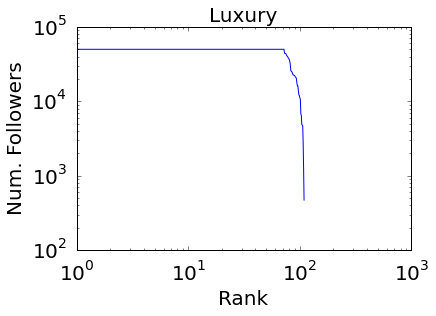

In [48]:
plot_follower_distribution(BRAND_DATA + '/luxury/exemplar_followers.txt', 'luxury_follower_counts.pdf', 'Luxury')

In [49]:
print_follower_stats(BRAND_DATA + '/luxury/exemplar_followers.txt')

110 total brands
4437242 total follow links
2337758 unique followers


In [53]:
def example_overlap():
    brand_followers = analyze.read_follower_file(BRAND_DATA + '/brand_followers.txt')
    eco_followers = analyze.read_follower_file(BRAND_DATA + '/eco/exemplar_followers.txt')
    all_eco = set()
    for f in eco_followers.values():
        all_eco.update(f)
    print('%d total exemplar followers' % len(all_eco))
    print('\t'.join(['brand', 'nfoll', 'match', 'pct']))
    for brand, followers in brand_followers.items():
        overlap = len(followers & all_eco)
        print('%20s\t%d\t%d\t%.4g' % (brand, len(followers), overlap, 1. * overlap / len(followers)))
example_overlap()

1043342 total exemplar followers
brand	nfoll	match	pct
       vaselinebrand	12971	523	0.04032
       oceansprayinc	16959	1196	0.07052
                jeep	299117	9185	0.03071
                puma	263433	3258	0.01237
         klondikebar	62490	3119	0.04991
         naturespath	30139	6967	0.2312
             clifbar	113085	7354	0.06503
       crackerbarrel	54223	1326	0.02445
         infinitiusa	74591	2738	0.03671
         miraclewhip	16971	477	0.02811
       bathbodyworks	232644	2959	0.01272
           nissanusa	201333	5932	0.02946
               levis	356571	6936	0.01945
        redken5thave	54979	946	0.01721
            mazdausa	130301	5316	0.0408
          specialkus	13988	513	0.03667
         ralphlauren	499998	11189	0.02238
           nikestore	499998	4142	0.008284
         teslamotors	258392	21429	0.08293
             yoplait	61159	2724	0.04454
         calvinklein	500000	9162	0.01832
          kelloggsus	33455	1855	0.05545
                 gap	301854	7186	0.02381
             pon

<a name="analysis"></a>
## Analysis

Next, we compute scores for each perception dimension. We consider several different scoring
algorithms, defined in `all_score_types`.

In [4]:
all_score_types

['cosine',
 'cosine_weighted_avg',
 'cosine_sqrt_no_weighted_avg',
 'cosine_sqrt',
 'jaccard',
 'jaccard_weighted_avg',
 'jaccard_sqrt_no_weighted_avg',
 'jaccard_sqrt',
 'proportion',
 'proportion_weighted_avg',
 'proportion_sqrt_no_weighted_avg',
 'proportion_sqrt']

In [ ]:
def compute_all_scores():
    score_types = all_score_types
    print('computing perception scores using functions:\n', score_types)
    perceptions = ['eco', 'nutrition', 'luxury']
    for perception in perceptions:
        for score_type in score_types:
            !brandelion analyze -n --brand-followers $BRAND_DATA/brand_followers.txt \
            --exemplar-followers $BRAND_DATA/$perception/exemplar_followers.txt \
            --network-method $score_type -o $BRAND_DATA/$perception/default/$score_type\.txt
            
compute_all_scores()

In [69]:
# The results are now here:
!echo eco
!head -2 $BRAND_DATA/eco/default/*.txt
!echo '\n' nutrition
!head -2 $BRAND_DATA/nutrition/default/*.txt
!echo '\n' luxury
!head -2 $BRAND_DATA/luxury/default/*.txt

eco
==> data/eco/default/cosine.txt <==
abercrombie 0.000486094
acura 0.00214509

==> data/eco/default/cosine_sqrt.txt <==
abercrombie 0.014211
acura 0.0288759

==> data/eco/default/cosine_sqrt_no_weighted_avg.txt <==
abercrombie 0.0220475
acura 0.0463152

==> data/eco/default/cosine_weighted_avg.txt <==
abercrombie 0.000201953
acura 0.000833818

==> data/eco/default/jaccard.txt <==
abercrombie 0.000123824
acura 0.000885569

==> data/eco/default/jaccard_sqrt.txt <==
abercrombie 0.00555709
acura 0.0152837

==> data/eco/default/jaccard_sqrt_no_weighted_avg.txt <==
abercrombie 0.0111276
acura 0.0297585

==> data/eco/default/jaccard_weighted_avg.txt <==
abercrombie 3.08813e-05
acura 0.000233592

==> data/eco/default/proportion.txt <==
abercrombie 0.000135901
acura 0.00124658

==> data/eco/default/proportion_sqrt.txt <==
abercrombie 0.00572708
acura 0.0170613

==> data/eco/default/proportion_sqrt_no_weighted_avg.txt <==
abercrombie 0.0116576
acura 0.0353069

==> data/eco/default/proportion_

<a name="analysis_evaluation"></a>
### Evaluation

To evaluate, we conduct an MTurk survey to collect perception of a sample of brands along each dimension. We then compare the survey results with the inferred social scores.

For example, we collect surveys of environmental friendliness for Apparel, Car, and Food brands:

In [72]:
!head -2 $BRAND_DATA/*/survey/*txt

==> data/eco/survey/apparel.txt <==
abercrombie	2.247148289
adidasus	2.554307116

==> data/eco/survey/car.txt <==
acura	2.744630072
astonmartin	1.886010363

==> data/eco/survey/food.txt <==
airheads	1.773504274
bertolli	2.565400844

==> data/eco/survey/personal_care.txt <==
aveda	3.397540984
axe	1.687719298

==> data/luxury/survey/apparel.txt <==
abercrombie	2.731034483
adidasus	2.188552189

==> data/luxury/survey/car.txt <==
acura	2.896457766
astonmartin	4.722713864

==> data/nutrition/survey/food.txt <==
bertolli	2.602649007
breyers	1.66873065


In [79]:
# for pretty printing
def prty(s):
    s = s.capitalize()
    d = {'Eco': 'Eco-Friendly',
         'Food': 'Food & Bev.',
         'Personal_care': 'Pers. Care'
         }
    if s in d:
        return d[s]
    return s

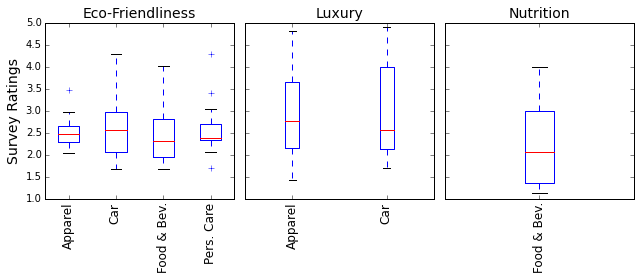

In [80]:
import glob
import matplotlib.pyplot as plt
import os

def make_boxplots(survey_path, title, axis):
    """ Print boxplots for each sector for one perception. """
    files = [f for f in glob.glob(survey_path + '/*txt')]
    data = []
    xticks = []
    for fi, survey_file in enumerate(files):
        data.append([float(l.split()[1]) for l in open(survey_file)])
        xticks.append(os.path.basename(survey_file).split('.')[0]) 
    axis.boxplot(data)
    axis.set_xticklabels([prty(x) for x in xticks], rotation=90, size=12)
    #axis.set_xticklabels(range(1, len(xticks)+1), xticks)
    axis.set_title(title, size=14)    
    
figure, axes = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(9, 4))
make_boxplots(BRAND_DATA + '/eco/survey', 'Eco-Friendliness', axes[0])
make_boxplots(BRAND_DATA + '/luxury/survey', 'Luxury', axes[1])
make_boxplots(BRAND_DATA + '/nutrition/survey', 'Nutrition', axes[2])
axes[0].set_ylabel('Survey Ratings', size=14)
figure.tight_layout()
plt.savefig('surveys.pdf', bbox_inches='tight')

In [86]:
from collections import defaultdict
import itertools
import math
from tabulate import tabulate

import brandelion.cli.report as report

def evaluate(version, score_types, perceptions, doplot=True):
    """ Evaluate the social scores against survey responses.
    Computes correlation, plots scatter plots, and prints table.
    Args:
      version........Name of the version of the analysis (e.g., 'default', or 'cutoff=5').
                     This is the name of the directory where the scores are located.
      score_types....List of names of network scoring types to evaluate (e.g., ['jaccard', 'rarity'])
      perceptions....List of (perception, [apparel_list]) tuples, e.g., [('eco', ['food', 'car']), ('nutrition', ['food'])]
    """
    table = defaultdict(lambda: [])
    for score_type in score_types:
        table[score_type].append(score_type)
    headers = ['method']
    for score_type in score_types:
        for perception, sectors in perceptions:
            for sector in sectors:
                name = perception + '-' + sector
                if name not in headers:
                    headers.append(name)
                # print perception, sector, score_type
                scores = report.read_scores('%s/%s/%s/%s.txt' % (BRAND_DATA, perception, version, score_type))
                validation = report.read_scores('%s/%s/survey/%s.txt' % (BRAND_DATA, perception, sector))
                report_dir = '%s/%s/%s/reports/%s/%s' % (BRAND_DATA, perception, version, score_type, sector)
                # print report_dir
                report.mkdirs(report_dir)
                corr = report.validate(scores, validation,
                                       '%s %s %s' % (perception, sector, score_type),
                                       report_dir, doplot)
                table[score_type].append(corr)
        table[score_type].append(np.mean(table[score_type][1:]))
    # print tabulate(table.values(), headers=headers, tablefmt="latex_booktabs")
    print(tabulate(table.values(), headers=headers + ['average'], tablefmt='pipe'))
    return table


Eco-Friendly / Apparel (0.62105191993502995, 2.4573422501522995e-05)
Eco-Friendly / Car (0.75245976915458623, 7.8410054054239301e-08)
Eco-Friendly / Food & Bev. (0.73272242786095232, 1.2912458874008534e-11)
Eco-Friendly / Pers. Care (0.81756977727083757, 1.0735239921135308e-05)
Luxury / Apparel (0.61792309318286687, 3.698619487356532e-06)
Luxury / Car (0.68303407079711986, 3.1926227213498359e-06)
Nutrition / Food & Bev. (0.79508303084687482, 4.1967486004999336e-13)


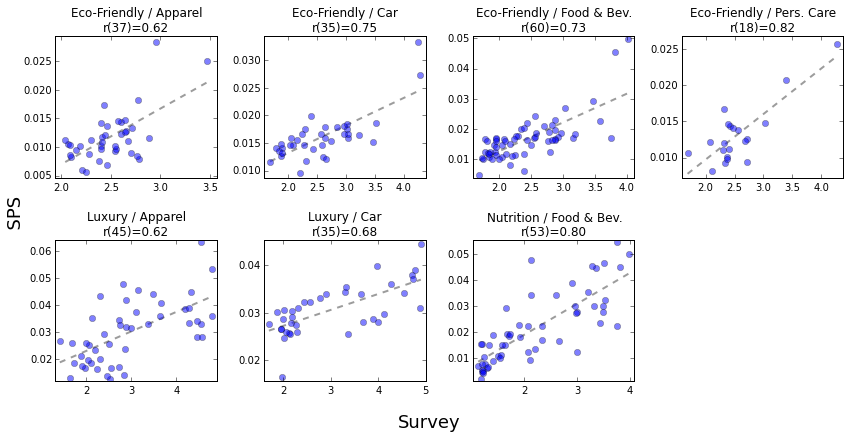

In [88]:
import scipy.stats as scistat
import string

def make_main_results_subfigure(axis, perception, sector, score_type, label_dict=dict(), remove_outliers=0):
    """
      remove_outliers....remove the top N values according to survey results.
    """
    name = prty(perception) + ' / ' + prty(sector)
    scores = report.read_scores('%s/%s/%s/%s.txt' % (BRAND_DATA, perception, 'default', score_type))
    validation = report.read_scores('%s/%s/survey/%s.txt' % (BRAND_DATA, perception, sector))
    if remove_outliers > 0:
        validation = dict(sorted(validation.items(), key=lambda x: x[1])[:-remove_outliers])
    keys = validation.keys()
    predicted = [scores[k] for k in keys]
    truth = [validation[k] for k in keys]
    corr = scistat.pearsonr(predicted, truth)
    print(name, corr)
    axis.set_title('%s\nr(%d)=%.2f' % (name, len(truth)-2, corr[0]))
    axis.set_ylim((min(predicted)-.001, max(predicted)+.001))
    axis.set_xlim((min(truth)-.1, max(truth)+.1))
    fit = np.polyfit(truth, predicted, 1)
    fit_fn = np.poly1d(fit)
    tr_extrema = [min(truth),max(truth)]
    axis.plot(tr_extrema,fit_fn(tr_extrema),'b--', linewidth=2, color='#9C9C9C')
    axis.plot(truth, predicted, 'bo', alpha=.5)
    for x, y, label in zip(truth, predicted, keys):
        if label in label_dict:
            axis.annotate(label_dict[label], xy=(x, y), xytext=(2, 2),
                     textcoords='offset points', size='12',
                     bbox=dict(boxstyle='round,pad=0.0', edgecolor='white',
                               fc='white', alpha=0.2))
    axis.locator_params(nbins=6, tight=True)   

    
def make_main_results_figure():
    score_type = 'jaccard_sqrt'
    perceptions = [('eco', ['apparel', 'car', 'food', 'personal_care']),
                  ('luxury', ['apparel', 'car']),
                  ('nutrition', ['food'])]
    figure, axes = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 6))
    axes = [x for x in itertools.chain(*axes)]
    # Turn off unused axes
    axes[-1].axis('off')
    axisi = 0
    for perception, sectors in perceptions:
        for sector in sectors:
            make_main_results_subfigure(axes[axisi], perception, sector, score_type, remove_outliers=0)
            axisi += 1
    plt.figtext(0.5,.04, 'Survey', fontdict={'fontsize':18}, verticalalignment='top', horizontalalignment='center')
    axes[4].set_ylabel('                                  SPS', size=18)
    plt.tight_layout()
    plt.savefig('scatters.pdf', bbox_inches='tight')
    plt.show()

make_main_results_figure()

Eco-Friendly / Car (0.75245976915458623, 7.8410054054239301e-08)
Luxury / Car (0.68303407079711986, 3.1926227213498359e-06)


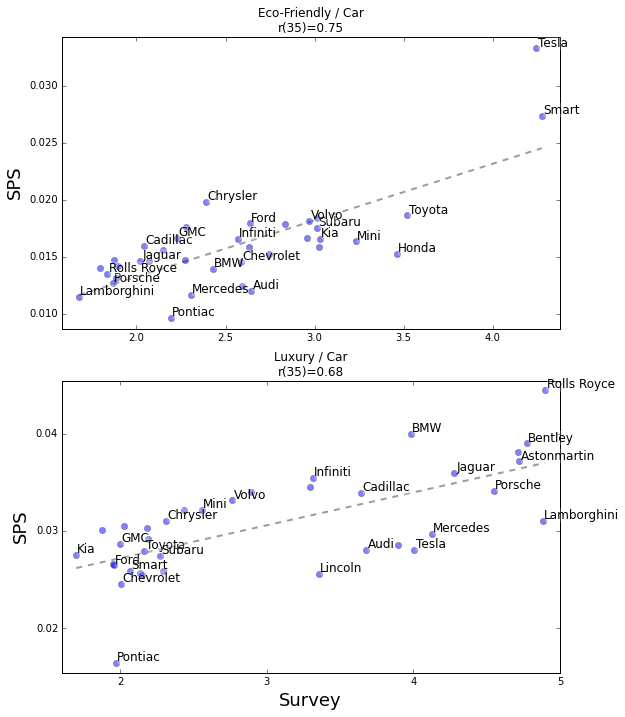

In [90]:
# Plot annotated graphs for cars.
def make_label_dict(handles, omit_labels):
    d = {}
    for h in handles:
        d[h] = h.capitalize()
    d['teslamotors'] = 'Tesla'
    d['smartcarusa'] = 'Smart'
    d['rollsroycecars'] = 'Rolls Royce'
    d['bmwusa'] = 'BMW'
    d['volvocarsus'] = 'Volvo'
    d['mercedesbenz'] = 'Mercedes'
    d['lincolnmotorco'] = 'Lincoln'
    d['thisisgmc'] = 'GMC'
    d['subaru_usa'] = 'Subaru'
    d['miniusa'] = 'Mini'
    d['bentleymotors'] = 'Bentley'
    d['infinitiusa'] = 'Infiniti'
    for k in omit_labels:
        d.pop(k, None)
    return d

omit_labels_eco = ['astonmartin', 'bentleymotors', 'maserati_hq', 'lexus', 'buick', 'dodge', 
                   'acura', 'nissanusa', 'landrover', 'hyundai', 'jeep', 'mitsucars', 
                   'scion', 'mazdausa', 'lincolnmotorco']
omit_labels_lux = ['honda', 'maserati_hq', 'lexus', 'buick', 'dodge', 
                   'acura', 'nissanusa', 'landrover', 'hyundai', 'jeep', 'mitsucars', 
                   'scion', 'mazdausa']

figure, axes = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(8, 10))
ecocars = set(report.read_scores('%s/%s/survey/%s.txt' % (BRAND_DATA, 'eco', 'car')).keys())
make_main_results_subfigure(axes[0], 'eco', 'car', 'jaccard_sqrt', make_label_dict(ecocars, omit_labels_eco))
luxcars = set(report.read_scores('%s/%s/survey/%s.txt' % (BRAND_DATA, 'luxury', 'car')).keys())
make_main_results_subfigure(axes[1], 'luxury', 'car', 'jaccard_sqrt', make_label_dict(luxcars, omit_labels_lux))
axes[1].set_xlabel('Survey', size=18)
axes[0].set_ylabel('SPS', size=18)
axes[1].set_ylabel('SPS', size=18)
plt.tight_layout()
plt.savefig('zoomed.pdf', bbox_inches='tight')
plt.show()

In [ ]:
results = evaluate('default',
                   all_score_types,
                   [('eco', ['apparel', 'car', 'food', 'personal_care']),
                        ('luxury', ['apparel', 'car']),
                    ('nutrition', ['food'])])
 

In [92]:
# Print a tex table summarizing all results.

table_vals = results['jaccard'][1:] + results['jaccard_weighted_avg'][1:] + results['jaccard_sqrt_no_weighted_avg'][1:] + results['jaccard_sqrt'][1:] + \
             results['cosine'][1:] + results['cosine_weighted_avg'][1:] + results['cosine_sqrt_no_weighted_avg'][1:] + results['cosine_sqrt'][1:] + \
             results['proportion'][1:] + results['proportion_weighted_avg'][1:] + results['proportion_sqrt_no_weighted_avg'][1:] + \
             results['proportion_sqrt'][1:]

outf = open('scores.tex', 'wt')
outf.write(r"""
\begin{tabular}{|r|r||c|c|c|c||c|c||c||c|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{4}{c||}{{\bf Eco-Friendliness}} & \multicolumn{2}{c||}{{\bf Luxury}} & {\bf Nutr.} & \\
\hline
{\bf Method} & {\bf Variant} & {\bf Appar.} & {\bf Car} & {\bf Food} & {\bf PC} & {\bf Appar.} & {\bf Car} & {\bf Food} & {\bf Avg.} \\
\hline
{\bf jaccard} & simp-avg   &  %.2f  &  %.2f  &  %.2f  &  \underline{%.2f}  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& wt-avg                   &  \underline{%.2f}  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& simp-avg, sqrt                       &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& {\bf wt-avg, sqrt}       &  \underline{{\bf %.2f}}  &  \underline{{\bf %.2f}}  &  \underline{{\bf %.2f}}  &  {\bf %.2f}  &  {\bf %.2f}  &  {\bf %.2f}  &  \underline{{\bf %.2f}}  &  \underline{{\bf %.2f}}  \\
\hline
{\bf cosine} & simp-avg    &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  \underline{%.2f}  &  %.2f  &  %.2f  &  %.2f  \\
& wt-avg                   &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  \underline{%.2f}  &  %.2f  &  %.2f  \\
& simp-avg, sqrt                       &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& wt-avg, sqrt             &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  \underline{%.2f}  \\
\hline
{\bf cnd-prob} & simp-avg &  \underline{%.2f}  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& wt-avg                   &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& simp-avg, sqrt                       &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
& wt-avg, sqrt             &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  &  %.2f  \\
\hline
\end{tabular}
""" % tuple(table_vals))
outf.close()

In [93]:
# Print table just for jaccard_sqrt
table_vals = results['jaccard_sqrt'][1:]
outf = open('jaccard_sqrt.tex', 'wt')
outf.write(r"""
\begin{tabular}{|c|c|c|c|}
\hline
{\bf Attribute} & {\bf Sector} & {\bf r} & {\bf N}\\
\hline
Eco & Apparel & %.2f & 39  \\
      & Car & %.2f &  37 \\
      & Food \& Beverage & %.2f & 62 \\
      & Personal Care & %.2f &  20 \\
\hline
Luxury & Apparel & %.2f & 47\\
           & Car  & %.2f & 37\\
\hline
Nutrition & Food \& Beverage & %.2f & 55\\
\hline
\multicolumn{2}{|r|}{{\bf Average}}  & %.2f & \\
\hline
\end{tabular}
""" % tuple(table_vals))
outf.close()


<a name="robustness"></a>
## Robustness Checks

Here we perform a number of robustness checks (c.f., Section 7).

<a name="sensitivity_min_followers"></a>
**A. Question:** How does the number of followers per exemplar affect results. (Fig 7b)



In [96]:
brand_followers = analyze.read_follower_file(BRAND_DATA + '/brand_followers.txt')
eco_exemplars = analyze.read_follower_file(BRAND_DATA + '/eco/exemplar_followers.txt', blacklist=brand_followers.keys())
nut_exemplars = analyze.read_follower_file(BRAND_DATA + '/nutrition/exemplar_followers.txt', blacklist=brand_followers.keys())
lux_exemplars = analyze.read_follower_file(BRAND_DATA + '/luxury/exemplar_followers.txt', blacklist=brand_followers.keys())

skipping exemplar audi
skipping exemplar ysl
skipping exemplar louisvuitton_us
skipping exemplar burberry
skipping exemplar versace
skipping exemplar hugoboss
skipping exemplar bentleymotors
skipping exemplar dior
skipping exemplar lamborghini
skipping exemplar porsche
skipping exemplar verawanggang
skipping exemplar chanel
skipping exemplar ralphlauren
skipping exemplar maserati_hq


In [ ]:
import random 

def get_corr(scores, validation):
    keys = sorted(validation.keys())
    keys = list(set(keys) & set(scores.keys()))
    predicted = [scores[k] for k in keys]
    truth = [validation[k] for k in keys]
    return scistat.pearsonr(predicted, truth)[0]
    
def do_n_followers_expt(brands, exemplars, perception, categories, avg_corrs, n=5):
    seeds = [12345, 54321, 11111, 22222]
    thresholds = [0, 10000, 25000, 40000, 50000]
    for seed in seeds:
        print('perception=%s seed=%d' % (perception, seed))
        random.seed(seed)
        for i, p in enumerate(thresholds):
            if i == 0:
                continue
            # get name of exemplars of correct size.
            exemplars_valid = [k for k, v in exemplars.items() if len(v) > thresholds[i-1] and len(v) <= p]
            print('thresh=%d, %d valid exemplars' % (p, len(exemplars_valid)))
            # get subset
            exemplars_sample = dict([(k, exemplars[k]) for k in random.sample(exemplars_valid, 5)])
            print('%d sampled exemplars' % len(exemplars_sample))
            # compute scores
            scores = analyze.jaccard_sqrt(brands.items(), exemplars_sample)
            print('computed %d brand scores' % len(scores))
            # evaluate
            for cat in categories:
                surveys = report.read_scores('%s/%s/survey/%s.txt' % (BRAND_DATA, perception, cat))
                corr = get_corr(scores, surveys)
                print('correlation with %s=%g' % (cat, corr))
                avg_corrs[p].append(corr)

perceptions = ['eco', 'nutrition', 'luxury']
avg_corrs = defaultdict(lambda: [])
do_n_followers_expt(brand_followers, eco_exemplars, 'eco', ['apparel', 'car', 'food', 'personal_care'], avg_corrs)
do_n_followers_expt(brand_followers, nut_exemplars, 'nutrition', ['food'], avg_corrs)
do_n_followers_expt(brand_followers, lux_exemplars, 'luxury', ['apparel', 'car'], avg_corrs)

10000 0.61
25000 0.69
40000 0.50
50000 0.52


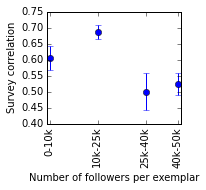

In [97]:
for k, v in sorted(avg_corrs.items()):
    print('%d %.2f' % (k, np.mean(v)))
    
thresholds = [10000, 25000, 40000, 50000]
plt.figure(figsize=(2.4, 2))
plt.errorbar(thresholds,
             [np.mean(avg_corrs[p]) for p in thresholds],
                 yerr=[np.std(avg_corrs[p]) / math.sqrt(len(avg_corrs[p])) for p in thresholds],
                 fmt='bo')
#plt.plot(thresholds, avg_corrs, 'bo')
plt.xlabel('Number of followers per exemplar')
plt.ylabel('Survey correlation')
plt.tick_params(axis='both', which='major')
plt.xlim(9000, 51000)
thresh_names = ['0-10k', '10k-25k', '25k-40k', '40k-50k']
plt.xticks(thresholds, thresh_names, rotation=90)

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.savefig('n_followers.pdf', bbox_inches='tight')

<hr>
<a name="sensitivity_nexemplars"></a>
**B. Question:** How does the number of exemplars affect correlation? (Fig 7a)

We randomly sample increasingly large number of exemplars and plot results.

In [ ]:
import math
import os
from matplotlib.ticker import FormatStrFormatter

def do_sample_exemplars_expt_helper(percents, seeds, score_types, perceptions):
    for seed in seeds:
        for pct in percents:
            expt_name = 'pct=%d' % pct
            for perception, sectors in perceptions:
                !mkdir -p $BRAND_DATA/$perception/nexemplars                
                for score_type in score_types:
                    !brandelion analyze -n --brand-followers $BRAND_DATA/brand_followers.txt \
                        --exemplar-followers $BRAND_DATA/$perception/exemplar_followers.txt \
                        --network-method $score_type -o $BRAND_DATA/$perception/nexemplars/seed=$seed/$expt_name/$score_type\.txt \
                        --sample-exemplars $pct --seed $seed

def do_sample_exemplars_expt():
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    seeds = [12345, 54321, 11111, 22222]
    score_types = ['jaccard_sqrt']
    perceptions =[('eco', ['apparel', 'car', 'food', 'personal_care']),
                          ('luxury', ['apparel', 'car']),
                          ('nutrition', ['food'])]
    do_sample_exemplars_expt_helper(percents, seeds, score_types, perceptions)
    # Evaluate
    avg_corrs = defaultdict(lambda: [])
    for seed in seeds:
        for pct in percents:
            print('evaluating pct=%d' % pct)
            res = evaluate('nexemplars/seed=%d/pct=%d' % (seed, pct),
                             score_types,
                             perceptions, doplot=False)
            avg_corrs[pct].append(np.mean([v for v in res.values()[0] if type(v) is not str]))

    
    fig = plt.figure(figsize=(2.4, 2))
    axis = plt.subplot(111)
    plt.errorbar(percents, [np.mean(avg_corrs[p]) for p in percents],
                 yerr=[np.std(avg_corrs[p]) / math.sqrt(len(avg_corrs[p])) for p in percents],
                 fmt='bo')
    plt.xlim((percents[0]-5, percents[-1]+5))
    plt.xlabel('% of exemplars')
    plt.ylabel('Survey correlation')
    plt.xticks(percents, ['%6d' % int(x) for x in percents], rotation=90)
    plt.savefig('n_exemplars.pdf', bbox_inches='tight')

    plt.show()

do_sample_exemplars_expt()

**Answer:** More exemplars helps a bit, but the bigger conclusion appears to be the high variance. This suggests that which exemplars is more important than how many. E.g., selecting the best 10 exemplars is better than including all of them.

<hr>

<a name="manual_exemplars"></a>
**C. Question:** Do manually collected eco exemplars outperform automatically collected? (c.f. Table 3)

The manually collected exemplars are in the `eco-nonprofit` subfolder.

In [99]:
# List manually selected exemplars.
print_lines(BRAND_DATA + '/eco-nonprofit/exemplars.txt')

There are 78 lines in data/eco-nonprofit/exemplars.txt

The first 5 are:
ACA_DC
AmazonWatch
AmericanForests
AppMtnClub
AsYouSow


In [ ]:
# Compute scores.
score_types = ['jaccard_sqrt']
for score_type in score_types:
    !brandelion analyze -n --brand-followers $BRAND_DATA/brand_followers.txt \
        --exemplar-followers $BRAND_DATA/eco-nonprofit/exemplar_followers.txt \
        --network-method $score_type -o $BRAND_DATA/eco-nonprofit/default/$score_type\.txt

Pearson: (0.74125827582650838, 6.7642237111981055e-08)


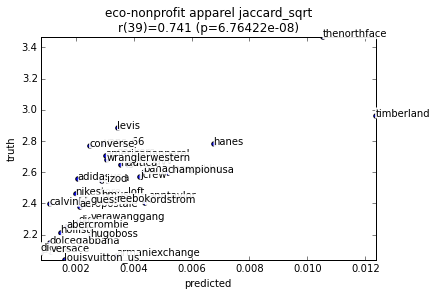

Pearson: (0.80123687178669656, 2.5708773172867278e-09)


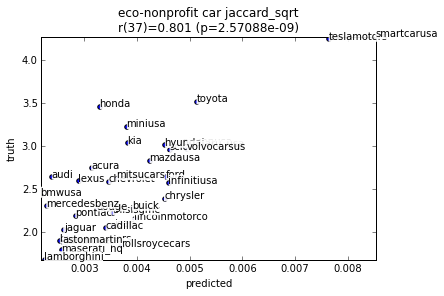

Pearson: (0.76461091483931609, 4.7405273215941606e-13)


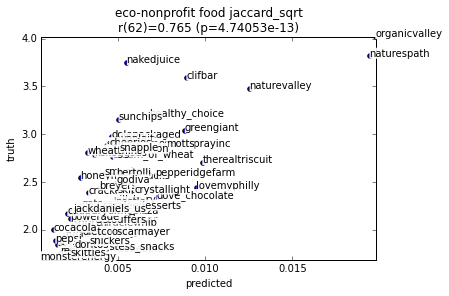

Pearson: (0.80493918353594252, 1.8666020055746151e-05)


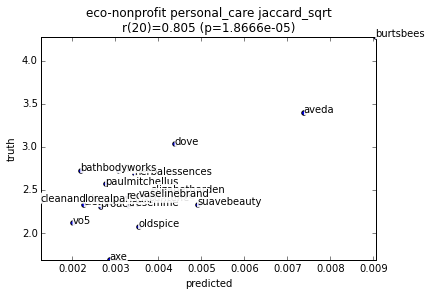

| method       |   eco-nonprofit-apparel |   eco-nonprofit-car |   eco-nonprofit-food |   eco-nonprofit-personal_care |   average |
|:-------------|------------------------:|--------------------:|---------------------:|------------------------------:|----------:|
| jaccard_sqrt |                0.741258 |            0.801237 |             0.764611 |                      0.804939 |  0.778011 |
Pearson: (0.62105191993502995, 2.4573422501522995e-05)


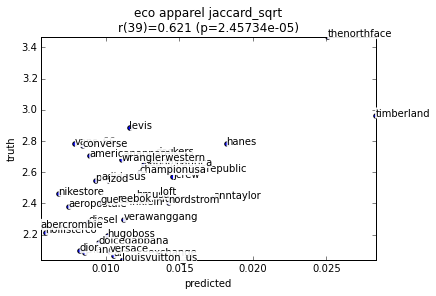

Pearson: (0.7524597691545859, 7.8410054054240717e-08)


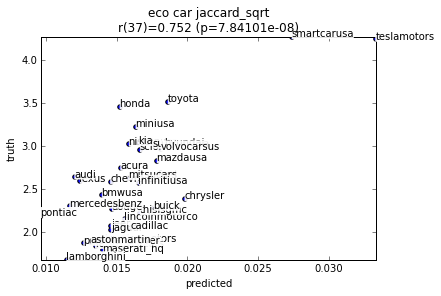

Pearson: (0.73272242786095243, 1.291245887400835e-11)


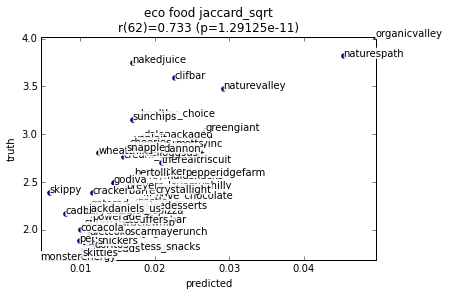

Pearson: (0.81756977727083757, 1.0735239921135308e-05)


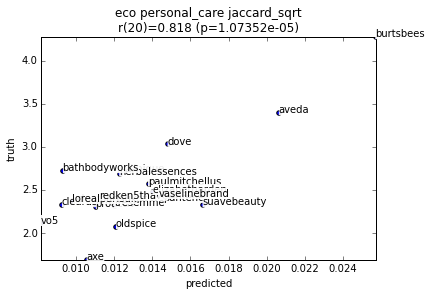

| method       |   eco-apparel |   eco-car |   eco-food |   eco-personal_care |   average |
|:-------------|--------------:|----------:|-----------:|--------------------:|----------:|
| jaccard_sqrt |      0.621052 |   0.75246 |   0.732722 |             0.81757 |  0.730951 |


defaultdict(<function __main__.evaluate.<locals>.<lambda>>,
            {'jaccard_sqrt': ['jaccard_sqrt',
              0.62105191993502995,
              0.7524597691545859,
              0.73272242786095243,
              0.81756977727083757,
              0.73095097355535144]})

In [102]:
eco_nonprofit_results = evaluate('default', ['jaccard_sqrt'], [('eco-nonprofit', ['apparel', 'car', 'food', 'personal_care'])], True)
evaluate('default', ['jaccard_sqrt'], [('eco', ['apparel', 'car', 'food', 'personal_care'])], True)

In [104]:
# Write tex table for eco results using charity navigator exemplars.
print(eco_nonprofit_results)
r = eco_nonprofit_results['jaccard_sqrt']
outf = open('charitynav_eco.tex', 'wt')
outf.write(r"""
\begin{tabular}{|c|c|c|c|}
\hline
{\bf Attribute} & {\bf Sector} & {\bf r} & {\bf N}\\
\hline
Eco & Apparel & %.2f & 39  \\
      & Car & %.2f &  37 \\
      & Food \& Beverage & %.2f & 62 \\
      & Personal Care & %.2f &  20 \\
\hline
\multicolumn{2}{|r|}{{\bf Average}}  & %.2f & \\
\hline

\end{tabular}
""" % (r[1], r[2], r[3], r[4], r[5]))
outf.close()

defaultdict(<function evaluate.<locals>.<lambda> at 0x135c42620>, {'jaccard_sqrt': ['jaccard_sqrt', 0.74125827582650838, 0.80123687178669656, 0.76461091483931609, 0.80493918353594252, 0.77801131149711589]})


**Answer:** Manual eco exemplars do a little bit better the auto-detected exemplars.

<hr>
<a name="exemplar_accuracy"></a>
**D. Question:** How does the correlation vary by exemplar? (c.f., Figure 8)

In [91]:
def do_correl_by_exemplar():
    score_types = ['jaccard_sqrt']
    perceptions =[('eco', ['apparel', 'car', 'food', 'personal_care']),
                          ('luxury', ['apparel', 'car']),
                          ('nutrition', ['food'])]
    for score_type in score_types:
        for perception, sectors in perceptions:
            for sector in sectors:
                print(perception, sector)
                !brandelion diagnose -n --brand-followers $BRAND_DATA/brand_followers.txt \
                --exemplar-followers $BRAND_DATA/$perception/exemplar_followers.txt \
                --network-method $score_type -v $BRAND_DATA/$perception/survey/$sector\.txt \
                --output $BRAND_DATA/$perception/diagnose/$sector\.txt

do_correl_by_exemplar()

eco apparel
{'--brand-followers': '/data/brandelion/mksci/brand_followers.txt',
 '--exemplar-followers': '/data/brandelion/mksci/eco/exemplar_followers.txt',
 '--network': True,
 '--network-method': 'jaccard_sqrt',
 '--output': '/data/brandelion/mksci/eco/diagnose/apparel.txt',
 '--validation': '/data/brandelion/mksci/eco/survey/apparel.txt',
 'diagnose': True}
read follower data for 74 exemplars
eco car
{'--brand-followers': '/data/brandelion/mksci/brand_followers.txt',
 '--exemplar-followers': '/data/brandelion/mksci/eco/exemplar_followers.txt',
 '--network': True,
 '--network-method': 'jaccard_sqrt',
 '--output': '/data/brandelion/mksci/eco/diagnose/car.txt',
 '--validation': '/data/brandelion/mksci/eco/survey/car.txt',
 'diagnose': True}
read follower data for 74 exemplars
eco food
{'--brand-followers': '/data/brandelion/mksci/brand_followers.txt',
 '--exemplar-followers': '/data/brandelion/mksci/eco/exemplar_followers.txt',
 '--network': True,
 '--network-method': 'jaccard_sqrt',


('forestservice', 0.724033)
('justingerdes', 0.819539)
('justingerdes', 0.755948)
('envam', 0.874151)
('chloefashion', 0.841719)
('forbeslife', 0.858411)
('nutritionnerd', 0.843461)


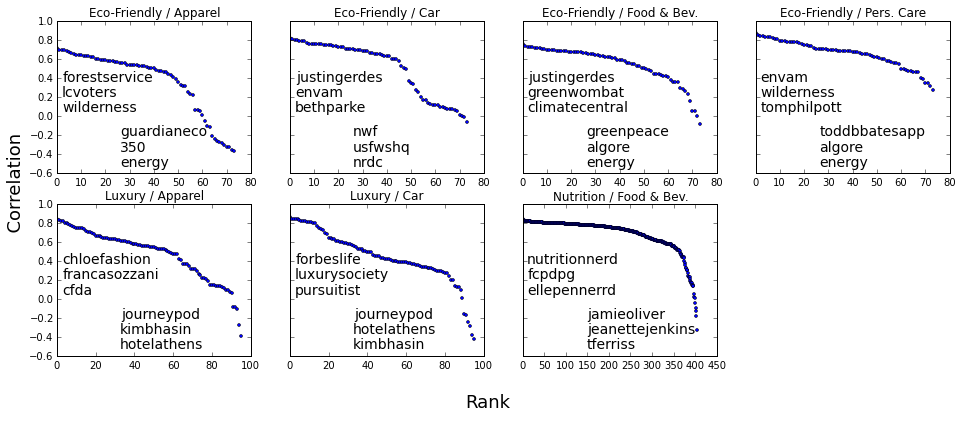

In [106]:
# Plot correlation by exemplar.
import itertools
import os

def plot_correl_by_exemplar():
    perceptions =[('eco', ['apparel', 'car', 'food', 'personal_care']),
                          ('luxury', ['apparel', 'car']),
                          ('nutrition', ['food'])]
    figure, axes = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(16, 6))
    axes = [x for x in itertools.chain(*axes)]
    axes[-1].axis('off')
    axi = 0
    for perception, sectors in perceptions:
        for sector in sectors:
            ax = axes[axi]
            fname = BRAND_DATA + '/' + perception + '/diagnose/' + sector + '.txt'
            if os.path.isfile(fname):
                data = [(l.split()[0], float(l.split()[1])) for l in open(fname, 'rt').readlines()[1:]]
                data = sorted(data, key=lambda x: -x[1])
                print(data[0])
                ax.set_title('%s / %s' % (prty(perception), prty(sector)))
                ax.plot([d[1] for d in data], 'bo', ms=3)
                # Add top accounts.
                ax.text(.03, .61, data[0][0], transform=ax.transAxes, size=14)
                ax.text(.03, .51, data[1][0], transform=ax.transAxes, size=14)
                ax.text(.03, .41, data[2][0], transform=ax.transAxes, size=14)
                ax.text(.33, .25, data[-3][0], transform=ax.transAxes, size=14)
                ax.text(.33, .15, data[-2][0], transform=ax.transAxes, size=14)
                ax.text(.33, .05, data[-1][0], transform=ax.transAxes, size=14)
            axi += 1
    plt.figtext(0.5,.04, 'Rank', fontdict={'fontsize':18}, verticalalignment='top', horizontalalignment='center')
    axes[4].set_ylabel('                                  Correlation', size=18)
    plt.savefig('exemplars.pdf', bbox_inches='tight')
    plt.show()
plot_correl_by_exemplar()

**Answer:** Using only a single exemplar can do as well or better than using all exemplars. The problem is that we don't know ahead of time which exemplar will work best. Thus, we average over all. There tend to be only a small percentage of exemplars that are poorly or even negatively correlated with survey responses (~10%).

<hr>
<a name="accuracy_v_exemplar_followers"></a>
**E. Question:** How does the number of followers of an exemplar effect its correlation with surveys? (c.f., Figure 9)



reading from data/eco/diagnose/apparel.txt
reading from data/eco/diagnose/car.txt
reading from data/eco/diagnose/food.txt
reading from data/eco/diagnose/personal_care.txt
[0.61977463095238094, 0.67915178125000009, 0.66878937500000002, 0.63995437499999996, 0.34991049604838714]
sizes= [84, 64, 8, 16, 124]
reading from data/luxury/diagnose/apparel.txt
reading from data/luxury/diagnose/car.txt
[0.16581181875000001, 0.36277121875000001, 0.49205979545454548, 0.21870534999999997, 0.52051749921875001]
sizes= [16, 16, 22, 10, 128]
reading from data/nutrition/diagnose/food.txt
[0.74668209440559441, 0.69402723255813947, 0.63764527272727278, 0.62300499999999992, 0.33006098200000006]
sizes= [286, 43, 11, 15, 50]


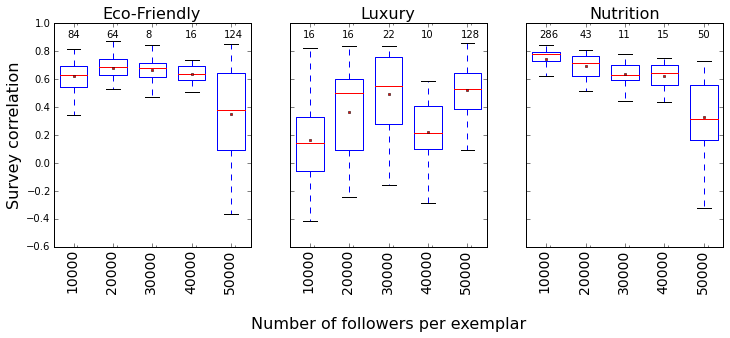

In [109]:
# This code assumes the prior experiment has been run, placing output in */diagnose/*.txt
import math
import os
import scipy.stats as scistat

def plot_correl_by_n_followers(minn=0, maxn=50000):
    perceptions =[('eco', ['apparel', 'car', 'food', 'personal_care']),
                          ('luxury', ['apparel', 'car']),
                          ('nutrition', ['food'])]
    bins = [10000, 20000, 30000, 40000, 50000]
    figure, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
    for axis, (perception, sectors) in zip(axes, perceptions):
        sizes = []
        correlations = []
        for sector in sectors:
            fname = BRAND_DATA + '/' + perception + '/diagnose/' + sector + '.txt'
            if os.path.isfile(fname):                
                print('reading from', fname)
                data = [(int(l.split()[2]), float(l.split()[1])) for l in open(fname, 'rt').readlines()[1:]]
                sizes.extend(d[0] for d in data if d[0] >= minn and d[0] <= maxn)
                correlations.extend(d[1] for d in data if d[0] >= minn and d[0] <= maxn)
        averages = []
        bindata = []
        for i, b in enumerate(bins):
            averages.append(np.mean([c for c, s in zip(correlations, sizes) if s <= b and s >= b - bins[0]]))
            bindata.append([c for c, s in zip(correlations, sizes) if s <= b and s >= b - bins[0]])
        print(averages)
        binsizes = [len(x) for x in bindata]
        print('sizes=', binsizes)
        corr = scistat.pearsonr(sizes, correlations)
        axis.set_title(prty(perception), size=16)
        axis.boxplot(bindata, showfliers=False, showmeans=True, widths=.7, meanprops={'markersize': 2})
        axis.set_xticks(np.arange(len(bins)) + 1.1, bins)
        axis.set_xticklabels(bins, rotation=90, size=14)
        for bi, size in enumerate(binsizes):
            axis.annotate(str(size), xy=((bi+1)-.15, .9))
    axes[0].set_ylabel('Survey correlation', size=16)
    axes[1].set_xlabel('\nNumber of followers per exemplar', size=16)
    plt.savefig('correl_v_followers.pdf', bbox_inches='tight')
    plt.show()

plot_correl_by_n_followers()

**Answer:** Number of followers is (weakly) negatively correlated with average survey correlation. This seems to vary a bit by sector.